# Face Recognition using VGG16 and SIFT descriptors
based on paper: Face Recognition Using the SR-CNN Model

# Connect to drive

# Import libraries

In [1]:
import os

import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import cv2

import matplotlib.pyplot as plt
from datetime import datetime
import io
import itertools
from packaging import version



import sklearn.metrics


In [ ]:
def normalize_mean_var(arr):
    arr -= np.mean(arr)
    arr /= np.var(arr)
    return arr

In [ ]:
# load only persons with more than 100
number_of_images = 50
iter_csv = pd.read_csv("LFW/lfw_allnames.csv", iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['images'] > number_of_images] for chunk in iter_csv])

topNames = set([x for x in df['name']])
#names.add('Bshara')
len(topNames)

# Prepare data

Generators

In [ ]:
#topNames = ('Tony_Blair','George_W_Bush', 'Gerhard_Schroeder', 'Donald_Rumsfeld', 'Colin_Powell', 'Bshara')

train_data_dir = "LFW/lfw-deepfunneled/lfw-deepfunneled"
img_width = img_height = 224
batch_size = 20

train_datagen = ImageDataGenerator( rescale = 1./255, validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=topNames,
    class_mode='categorical',
    subset='training') # set as training data


validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    classes=topNames,
    class_mode='categorical',
    subset='validation') # set as validation data




In [ ]:
# import the necessary packages
from skimage import feature
import numpy as np
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        # store the number of points and radius
        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        # compute the Local Binary Pattern representation
        # of the image, and then use the LBP representation
        # to build the histogram of patterns
        lbp = feature.local_binary_pattern(image, self.numPoints,
        self.radius, method="ror")
        (hist, _) = np.histogram(lbp.ravel(),
        bins=np.arange(0, self.numPoints + 3),
        range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist



In [ ]:
import math
D = math.sqrt(224**2 + 224**2)
r = 16
m = 32
ritf_desc = LocalBinaryPatterns(m-2, r)

def get_image_histogram(img, ritf_desc):

   
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # load the image, convert it to grayscale, and describe it
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ritf = ritf_desc.describe(gray)
    
    return ritf


# Preprocessing data

In [ ]:
from IPython.display import clear_output


In [ ]:
def preprocess(gen, ritf_desc):
    res = []
    for i in range(len(gen)):
        clear_output(wait=True)
        print("{}/{}".format(i, len(gen)))
        x, y = gen[i]
        #sift = np.asarray([get_image_histogram(img, ritf_desc) for img in x])
        res.append([x, y])
    return np.asarray(res)


In [ ]:
traing_data = preprocess(train_generator, ritf_desc)
valid_data = preprocess(validation_generator, ritf_desc)

In [ ]:
train_path = "npy_saves/Train_imc_50.npy"
valid_path = "npy_saves/valid_imc_50.npy"

np.save(train_path, traing_data)
np.save(valid_path, valid_data)

In [ ]:
traing_data[0][0].shape

# Training

In [ ]:
def label_converter(arr):
    for i in range(len(arr)):
        if arr[i] == 1:
            return i
    return -1

In [ ]:
def remove_batches(arr):
    X = []
    y = []
    for j in range(len(arr)):
        batch = arr[j]
        for i in range(len(batch[0])):
            gray = cv2.cvtColor(batch[0][i], cv2.COLOR_BGR2GRAY)
            X.append(gray)
            y.append(label_converter(batch[1][i]))
        
    return np.asarray(X), np.asarray(y)

In [ ]:
X_traing, y_training = remove_batches(traing_data)

In [ ]:
X_validation, y_validation = remove_batches(valid_data)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix(model, X_test, y_test, title):
    disp = plot_confusion_matrix(model, X_test, y_test,
                                display_labels=[x for x in range(len(topNames))],
                                cmap=plt.cm.Blues,
                                normalize='true')
    disp.ax_.set_title('Confusion matrix: ' + title)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_traing_hists, y_training)

pred = clf.predict(X_valid_hists)
cnf_matrix = metrics.confusion_matrix(y_validation, pred)
RF_acc = metrics.accuracy_score(y_validation, pred)

print("Random Forest Accuracy:", RF_acc)
confusion_matrix(clf, X_valid_hists, y_validation, "Random Forst")

In [ ]:
from sklearn.svm import LinearSVC
# train a Linear SVM on the data
model = LinearSVC(C=100.0, random_state=42)
model.fit(X_traing_hists, y_training)

pred = model.predict(X_valid_hists)
cnf_matrix = metrics.confusion_matrix(y_validation, pred)
RF_acc = metrics.accuracy_score(y_validation, pred)

print("Random Forest Accuracy:", RF_acc)
confusion_matrix(model, X_valid_hists, y_validation, "Random Forst")

In [ ]:
imgs = train_generator[0][0]
fig=plt.figure(figsize=(3, 3))
plt.imshow(imgs[0])
plt.show()

In [ ]:
model = cv2.face.LBPHFaceRecognizer_create(radius=16, neighbors=1)
model.train(X_traing, y_training)

In [ ]:
len(X_traing)

In [ ]:
model.getHistograms()[0].shape

In [ ]:
def getHistogramss(X_data, y_data, rad, neig):
    model = cv2.face.LBPHFaceRecognizer_create(radius=rad, neighbors=neig)
    model.train(X_data, y_data)
    X = []
    arr = model.getHistograms()
    for i, h in enumerate(arr):
        hist = h[0]
        X.append(hist)
    return X

d = {}
for i in range(1, 15):

    for j in range(1, 15):
        X_traing_hists = getHistogramss(X_traing, y_training, j, i)     
        X_valid_hists = getHistogramss(X_validation, y_validation, j, i)

        from sklearn.svm import LinearSVC
        # train a Linear SVM on the data
        model = LinearSVC(C=100.0, random_state=42)
        model.fit(X_traing_hists, y_training)

        pred = model.predict(X_valid_hists)
        cnf_matrix = metrics.confusion_matrix(y_validation, pred)
        RF_acc = metrics.accuracy_score(y_validation, pred)
        d[(j, i)] = RF_acc
        print("Random Forest Accuracy in rad={}, neig={}: {}".format(j, i, RF_acc))
    #confusion_matrix(model, X_valid_hists, y_validation, "Random Forst")
        

In [ ]:
# prepare model
i, j = 8, 9
X_traing_hists = getHistogramss(X_traing, y_training, j, i)     
X_valid_hists = getHistogramss(X_validation, y_validation, j, i)

from sklearn.svm import LinearSVC
# train a Linear SVM on the data
model = LinearSVC(C=100.0, random_state=42)
model.fit(X_traing_hists, y_training)

pred = model.predict(X_valid_hists)
cnf_matrix = metrics.confusion_matrix(y_validation, pred)
RF_acc = metrics.accuracy_score(y_validation, pred)
d[(j, i)] = RF_acc
print("Random Forest Accuracy in rad={}, neig={}: {}".format(j, i, RF_acc))

In [ ]:
# number of features is 16384
len(X_traing_hists[0])

In [ ]:
# feature selection
from sklearn.feature_selection import RFE
estimator = LinearSVC(C=100.0, random_state=42, max_iter=2000)
selector = RFE(estimator, n_features_to_select=128, step=64, verbose=1)
selector = selector.fit(X_traing_hists, y_training)
print(selector.support_)
print(selector.ranking_)

In [ ]:
def get_selected_features(dataArr, trueValues):
    res = []
    for i, v in enumerate(dataArr):
        if trueValues[i]:
            res.append(v)
    return np.asarray(res)

def get_selected_features_mat(dataMat, trueValues):
    res = []
    for v in dataMat:
        res.append(get_selected_features(v, trueValues))
    return res
        
X_traing_hists_reduced = get_selected_features_mat(X_traing_hists, selector.support_)
X_valid_hists_reduced = get_selected_features_mat(X_valid_hists, selector.support_)

In [ ]:

from sklearn.svm import LinearSVC
# train a Linear SVM on the data
model = LinearSVC(C=100.0, random_state=42, max_iter=10000)
model.fit(X_traing_hists_reduced, y_training)

pred = model.predict(X_valid_hists_reduced)
cnf_matrix = metrics.confusion_matrix(y_validation, pred)
RF_acc = metrics.accuracy_score(y_validation, pred)
print("LinearSVC Accuracy: {}".format(RF_acc))
confusion_matrix(model, X_valid_hists_reduced, y_validation, "LinearSVC")


# Saving

In [ ]:
ritf_hist_train_path = "npy_saves/RITF_hist_reduced_128_train_imc_50.npy"
ritf_hist_valid_path = "npy_saves/RITF_hist_reduced_128_valid_imc_50.npy"

np.save(ritf_hist_train_path, X_traing_hists_reduced)
np.save(ritf_hist_valid_path, X_valid_hists_reduced)

In [ ]:
feature_sel = selector.support_[:]
feature_sel = np.asarray(feature_sel)
ritf_feature_selection_path = "npy_saves/RITF_feature_selection_128_valid_imc_50.npy"
np.save(ritf_feature_selection_path, feature_sel)

In [ ]:
train_path = "npy_saves/Train_imc_50.npy"
valid_path = "npy_saves/valid_imc_50.npy"

np.save(train_path, traing_data)
np.save(valid_path, valid_data)

In [ ]:
y_train_path = "npy_saves/y_train_imc_50.npy"
y_valid_path = "npy_saves/y_valid_imc_50.npy"

np.save(y_train_path, y_training)
np.save(y_valid_path, y_validation)

# Loading the data

In [2]:
ritf_hist_train_path = "npy_saves/RITF_hist_reduced_128_train_imc_50.npy"
ritf_hist_valid_path = "npy_saves/RITF_hist_reduced_128_valid_imc_50.npy"

X_traing_hists_reduced = np.load(ritf_hist_train_path)
X_valid_hists_reduced = np.load(ritf_hist_valid_path)

In [3]:
y_train_path = "npy_saves/y_train_imc_50.npy"
y_valid_path = "npy_saves/y_valid_imc_50.npy"

y_training = np.load(y_train_path)
y_validation = np.load(y_valid_path)

# Training

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix(model, X_test, y_test, title):
    disp = plot_confusion_matrix(model, X_test, y_test,
                                cmap=plt.cm.Blues,
                                normalize='true')
    disp.ax_.set_title('Confusion matrix: ' + title)

Random Forest Accuracy: 0.788961038961039


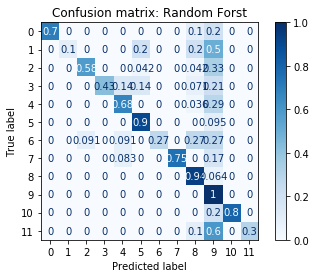

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_traing_hists_reduced, y_training)

pred = clf.predict(X_valid_hists_reduced)
cnf_matrix = metrics.confusion_matrix(y_validation, pred)
RF_acc = metrics.accuracy_score(y_validation, pred)

print("Random Forest Accuracy:", RF_acc)
confusion_matrix(clf, X_valid_hists_reduced, y_validation, "Random Forst")

In [ ]:
def SVM_classification(X_train, X_test, y_train, y_test):
    #SVM
    from sklearn.svm import SVC

    for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
        svc= SVC(kernel = kernel)

        svc.fit(X_train, y_train)
        svcpred = svc.predict(X_test)
        cnf_matrix = metrics.confusion_matrix(y_test, svcpred)
        SVC_acc = metrics.accuracy_score(y_test, svcpred)

        print('SVC (kernel = {}): '.format(kernel),SVC_acc)
        title = 'SVC (kernel = {}): '.format(kernel)
        confusion_matrix(svc, X_test, y_test, title)
        
SVM_classification(X_traing_hists_reduced, X_valid_hists_reduced, y_training, y_validation)